# Constructing and Using the CNTK for Image Inpainting/Reconstruction

In this notebook, we provide simple examples of using the CNTK for inpainting/reconstructing high resolution images. 

For image resolutions under 256 x 256 and for networks with at most 5 layers of downsampling/upsampling, it is feasible to perform all the computation on the CPU.  All computation for constructing the kernel is on the CPU and parallelized across CPU threads.  

For simplicity, we make the following assumptions about the neural networks used: 

1. The first layer is a convolutional layer.  
2. Each convolutional layer is followed by a nonlinearity.  For this library, we have implemented the dual activation functions for ReLU and LeakyReLU.  

We have tried to match the notation from PyTorch as much as possible for constructing neural network architectures.  The available layers are Convolutional, ReLU, LeakyReLU, Downsample, and Upsample.  

## Overview of Kernel Regression with the CNTK 

#### This section is a high level overview describing our method.  It is primarily for those without a background in kernel regression. 

Before showcasing the CNTK for image inpainting, we provide an overview of what it means to use the CNTK for image inpainting.  Let us suppose we are first given an image of resolution $256 \times 256$ that is corrupted as follows.  

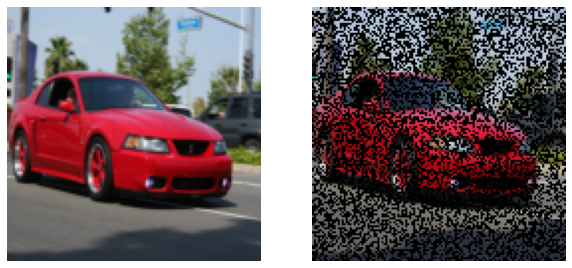

In [1]:
import utilities.load_image as loader
import mpld3
mpld3.enable_notebook()

fname = 'data/car.jpg'
clean, corrupted, mask = loader.load_image(fname, img_width=128, img_height=128)
loader.visualize_corrupted_image(clean, corrupted)

### Imputing Missing Entries as a Linear Combination of Other Entries

Our goal is to recover the clean image given only the corrupted one shown on the right.  To do this, we will write each missing pixel as a linear combination of all observed pixels in the image.  

How do we select the coeffificents used in the linear combinations? Well, we will select these coefficients by constructing a four dimensional array, $K$, of size $256 \times 256 \times 256 \times 256$ that has the following property.

Entry $(i,j, i', j')$ of this array should indicate similarity between the pixels at coordinate $(i,j)$ and $(i',j')$ in the image.  For example, we would expect $K(1, 1, 1, 2)$ to be much larger than $K(1, 1, 128, 128)$ since coordinates $(1,1)$ and $(1,2)$ are much closer to each other than $(1, 1)$ and $(128, 128)$.  

Our method will automatically construct an array $K$ that satisifies the property above.

### Using the CNTK to Compute the Coefficients of this Linear Combination

Once we have the array $K$ from the CNTK, how do we actually use it to fill in the missing pixels in the image above?  

We will first reshape $K$ to be a matrix of size $256^2 \times 256^2$.  As not all pixels are observed in the image, we need to remove all rows and columns of $K$ that correspond to coordinates where a pixel is missing.  Let us call the remaining matrix $K_{train}$.  For example, if we assume that exactly half the pixels in the image above are discarded, then $K_{train}$ is of size $128^2 \times 128^2$.  

Recall that every entry $(a,b)$ in $K_{train}$ actually corresponds to a entry for pair of pixel coordinates $(a_i, a_j), (b_i, b_j)$ in the original four dimensional array.  For each row $a$ of $K_{train}$, let us also associate a value $y_{a}$, which is just the value of the observed pixel at coordinate $(a_i, a_j)$ in the image.  We will thus have $128^2$ values $\{y_{a}\}$, which we can concatenate into a vector $y$.  

We will then solve the following linear system for the vector $w$:  $$ K_{train} w = y \implies w = K_{train}^{-1} y$$

To finally compute the value for a missing pixel, we just select the column, $k$, in $K$ corresponding to the missing pixel and then just compute: $$ k w = k K_{train}^{-1} y$$

While simple, our work shows that the above procedure performs remarkably well.  In this notebook, we walk through the full computation for the above example.   

## Our API for Constructing the CNTK given an Neural Network Architecture
Below we begin with an example of constructing the CNTK for a 16 x 16 image for the following simple architecture:

In [2]:
import construct_kernel.layers as nn

# Construct a network for which we will compute the CNTK 
net = nn.Sequential(nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),                    
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),      
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),                    
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3))

Just like in PyTorch, you can specify the filter size (i.e. "kernel_size") for convolutional layers, and you can specify whether the upsampling layer should be bilinear or nearest neighbor upsampling.  

Next, we will get the NTK for the above architecture.  This is done using the "get_ntk" function.  This function takes in an image size, $d$, a number of CPU threads to parallel computation over, and optionally takes in a feature prior $X \in \mathbb{R}^{c \times d \times d}$ (by default, the prior is assumed to correspond to a stationary distribution).  

In [3]:
# Provide an image size, number of CPU threads, and possibly a feature prior X for computing the kernel 
image_size = 16
K = net.get_ntk(image_size, num_threads=10)

100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


If we look at the shape of $K$ computed above, we see that it is of size $16 \times 16 \times 16 \times 16$.  This is exactly the four dimensional array that we will index for imputing missing pixel values.  

In [4]:
print(K.shape)

(16, 16, 16, 16)


## Filling in Missing Pixel Values with the CNTK 

We will now use the kernel, $K$, computed above to fill in pixel values in our missing image.  Note that $K$ is of size $(16, 16, 16, 16)$, but we are fi/lling in an image of size $256 \times 256$.  Hence, we need to use the expansion trick from our paper to expand $K$ to the kernel $\tilde{K}$ for $256 \times 256$ images.  

Loaded Kernel; Now Subsetting Observed Entries
Starting exact solve for kernel regression
This system has 8137 equations & unknowns.
6.178486585617065  time for solve


e:\GraduateCourses\MatrixAnalysis\Homeworks\project\refs\ntk_matrix_completion-main\image_inpainting_notebooks\utilities\visualizer.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


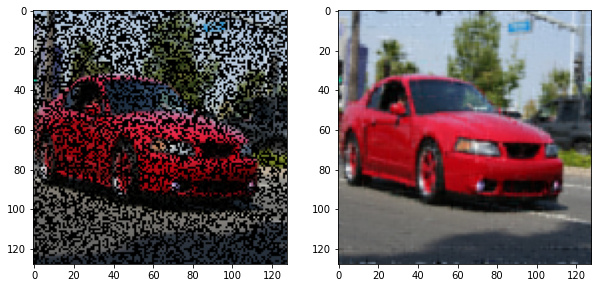

In [4]:
import kr_solvers.expander as expander
import kr_solvers.exact_solve as exact_solve
import utilities.visualizer as vis

s = 3  # Number of downsampling / upsampling layers in network
_, w, h = corrupted.shape  # Shape to expand our kernel to (we only need width and height)
K_expanded = expander.expand_kernel(K, s, w, h)
imputed_img_exact = exact_solve.kr_solve(K_expanded, corrupted, mask)
vis.visualize_images(corrupted, imputed_img_exact)

## Visualizing Kernel Entries
The expanded kernel gives us insight into how a missing pixel is being filled in as a linear combination of other pixels.  In particular, the expanded kernel, $K_{expanded}$, above will now be a 4 dimensional array of size $256 \times 256 \times 256 \times 256$ where $K_{expanded}(i, j, i', j')$ indicates how the pixel at coordinate $(i', j')$ is used for filling in the pixel at coordinate $(i, j)$.  

For any missing coordinate $(i,j)$, we thus visualize $K_{expanded}(i, j, :, :)$ as a matrix of size $256 \times 256$ to understand how other pixels are used to fill in the pixel at $(i,j)$.  We do this below for a few missing pixel coordinates.  

e:\GraduateCourses\MatrixAnalysis\Homeworks\project\refs\ntk_matrix_completion-main\image_inpainting_notebooks\utilities\visualizer.py:34: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


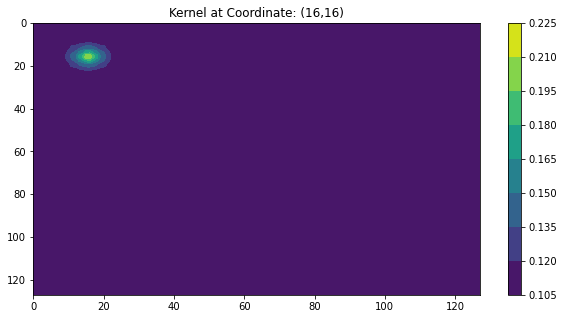

In [5]:
import utilities.visualizer as vis

vis.visualize_kernel_slice(K_expanded, (16, 16))

## Inpainting Large Images with EigenPro

Thus far, we have walked through a simple of reconstructing a corrupted image with the CNTK by directly solving kernel regression.  Unfortunately, solving a linear system of equations where the number of variables scales with the number of pixels becomes computationally impractical for high resolution inpainting.  

Fortunately, pre-conditioned gradient descent methods like Eigen-Pro (see https://arxiv.org/abs/1703.10622) enable us to scale the CNTK to high resolution images.  We now walk through a simple example of using the CNTK + EigenPro to quickly inpaint high resolution images. 

#### *The code below is drastically sped up if a GPU is available.  

(8137, 2) (8137, 3)
Training Model


e:\GraduateCourses\MatrixAnalysis\Homeworks\project\refs\ntk_matrix_completion-main\image_inpainting_notebooks\kr_solvers\eigenpro.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(data, dtype=dtype,


SVD time: 2.06, top_q: 212, top_eigval: 0.26, new top_eigval: 4.71e-04
n_subsamples=2000, bs_gpu=2000, eta=2026.13, bs=2000, top_eigval=2.57e-01, beta=0.99
train error: 0.22405	 (0 epochs, 0.00 seconds)
train error: 0.00124	 (10 epochs, 0.75 seconds)
train error: 0.00057	 (20 epochs, 1.48 seconds)


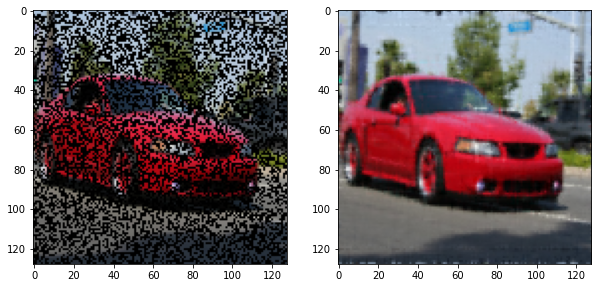

In [6]:
import kr_solvers.eigenpro_solve as eigenpro_solve
import utilities.visualizer as vis

s = 3  # Number of downsampling / upsampling layers in network
imputed_img = eigenpro_solve.expand_and_solve(K, corrupted, mask, s, max_iter=20)
vis.visualize_images(corrupted, imputed_img)

# Using a Cached Kernel

Along with the ability to construct the CNTK for a given architecture, we provide a number of cached kernels for image inpainting.  These kernels are saved via the "hickle" library (i.e. HDF5 files).  We provide an example of loading and inpainting with a cached kernel below.  

### Inpainting with the Meshgrid Feature Prior

In [8]:
import utilities.load_image as loader
import hickle

fname = 'data/hill_GT.png'
clean, corrupted, mask = loader.load_image(fname, img_width=128, img_height=128)

# 6 down/upsampling layers, meshgrid feature prior
K = hickle.load('saved_kernels/128x128_6ud_dip_meshgrid.h')  

Loaded Kernel; Now Subsetting Observed Entries
Starting exact solve for kernel regression
This system has 8225 equations & unknowns.
6.650082111358643  time for solve


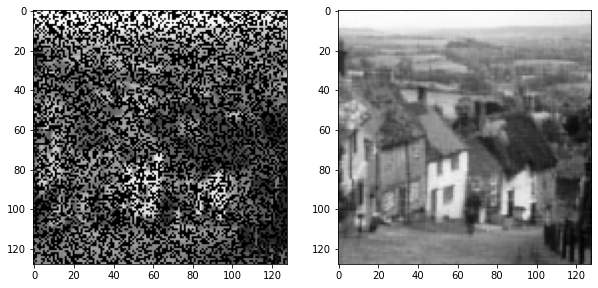

In [9]:
# Exact solver for cached kernel
import kr_solvers.expander as expander
import kr_solvers.exact_solve as exact_solve
import utilities.visualizer as vis

imputed_img_exact = exact_solve.kr_solve(K, corrupted, mask)
vis.visualize_images(corrupted, imputed_img_exact)

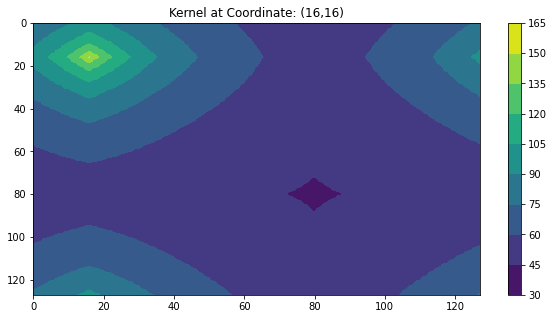

In [10]:
# Visualize kernel slices for expanded kernel
vis.visualize_kernel_slice(K, (16, 16))

(8225, 2) (8225, 1)
Training Model
SVD time: 2.03, top_q: 104, top_eigval: 0.20, new top_eigval: 4.76e-04
n_subsamples=2000, bs_gpu=2000, eta=2076.85, bs=2000, top_eigval=2.01e-01, beta=0.96
train error: 0.22701	 (0 epochs, 0.00 seconds)
train error: 0.00084	 (10 epochs, 0.54 seconds)
train error: 0.00042	 (20 epochs, 1.07 seconds)
train error: 0.00028	 (30 epochs, 1.58 seconds)
train error: 0.00020	 (40 epochs, 2.11 seconds)
train error: 0.00015	 (50 epochs, 2.63 seconds)
train error: 0.00012	 (60 epochs, 3.15 seconds)
train error: 0.00010	 (70 epochs, 3.67 seconds)
train error: 0.00008	 (80 epochs, 4.19 seconds)
train error: 0.00007	 (90 epochs, 4.71 seconds)
train error: 0.00006	 (100 epochs, 5.23 seconds)


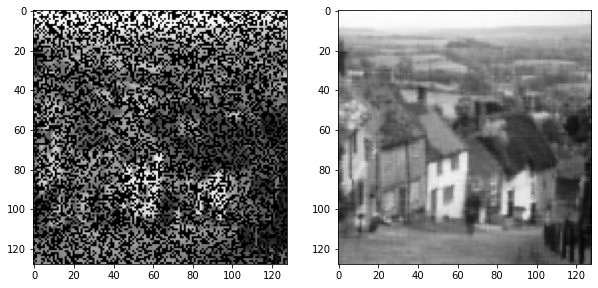

In [11]:
# EigenPro solve for cached kernel
imputed_img = eigenpro_solve.solve(K, corrupted, mask, max_iter=100)
vis.visualize_images(corrupted, imputed_img)

### Large Hole Inpainting with the Identity Feature Prior

In [12]:
# 6 down/upsampling layers, identity feature prior
K = hickle.load('saved_kernels/128x128_6ud_dip_identity.h')

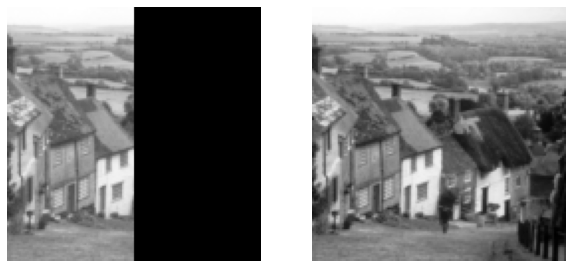

In [16]:
import numpy as np
# Large hole inpainting with the identity prior
mask = np.zeros(corrupted.shape)
mask[:, :, :64] = 1
corrupted = mask * clean
loader.visualize_corrupted_image(corrupted, clean)

(8192, 2) (8192, 1)
Training Model
SVD time: 2.09, top_q: 123, top_eigval: 0.18, new top_eigval: 4.70e-04
n_subsamples=2000, bs_gpu=2000, eta=2087.54, bs=2000, top_eigval=1.80e-01, beta=0.96
train error: 0.26855	 (0 epochs, 0.00 seconds)
train error: 0.00053	 (10 epochs, 0.52 seconds)
train error: 0.00028	 (20 epochs, 1.03 seconds)
train error: 0.00019	 (30 epochs, 1.53 seconds)
train error: 0.00014	 (40 epochs, 2.05 seconds)
train error: 0.00012	 (50 epochs, 2.56 seconds)
train error: 0.00010	 (60 epochs, 3.07 seconds)
train error: 0.00009	 (70 epochs, 3.58 seconds)
train error: 0.00008	 (80 epochs, 4.09 seconds)
train error: 0.00007	 (90 epochs, 4.60 seconds)
train error: 0.00007	 (100 epochs, 5.11 seconds)


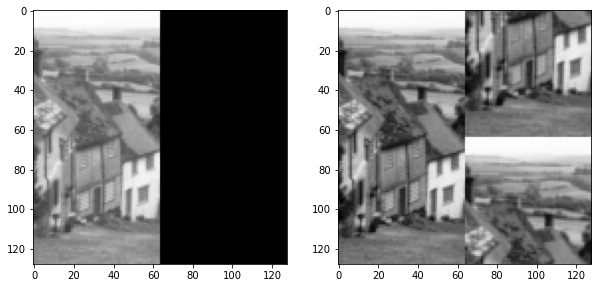

In [14]:
imputed_img = eigenpro_solve.solve(K, corrupted, mask, max_iter=100)
vis.visualize_images(corrupted, imputed_img)

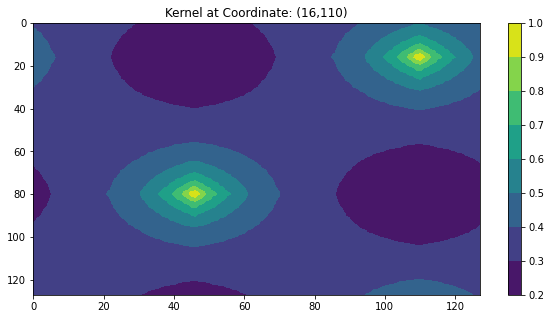

In [15]:
# Visualize kernel slices for expanded kernel
vis.visualize_kernel_slice(K, (16, 110))